In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
FOLD=3

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *
from efficientnet_pytorch import EfficientNet
from fastaudio.augment.spectrogram import CropTime

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_everything(1234)

In [6]:
path = Path("/home/kkalyan/agri-split/data")

In [7]:
(path/"audio_files").ls()

(#2126) [Path('/home/kkalyan/agri-split/data/audio_files/BK8UDCM.wav'),Path('/home/kkalyan/agri-split/data/audio_files/3B5A2P3.wav'),Path('/home/kkalyan/agri-split/data/audio_files/7QXN2WO.wav'),Path('/home/kkalyan/agri-split/data/audio_files/E04FSN7.wav'),Path('/home/kkalyan/agri-split/data/audio_files/O0L4PC1.wav'),Path('/home/kkalyan/agri-split/data/audio_files/0TYHMIF.wav'),Path('/home/kkalyan/agri-split/data/audio_files/48PTKS5.wav'),Path('/home/kkalyan/agri-split/data/audio_files/J28NE2C.wav'),Path('/home/kkalyan/agri-split/data/audio_files/3J8WKXR.wav'),Path('/home/kkalyan/agri-split/data/audio_files/67FIJLB.wav')...]

In [8]:
df = pd.read_csv(path/"Train_v.csv")
df.head()

,fn,label,fold
0,audio_files/IV38R7F.wav,akawuka,1
1,audio_files/KM4SKWT.wav,banana,1
2,audio_files/F5POSU9.wav,obulwadde,3
3,audio_files/MMVDXG2.wav,nnyaanya,1
4,audio_files/9TVM96F.wav,pampu,1


In [9]:
ct = CropTime(duration=1000)
cfg = AudioConfig.BasicMelSpectrogram(n_fft=512)
a2s = AudioToSpec.from_cfg(cfg)

In [10]:
def CrossValidationSplitter(col='fold', fold=1):
    "Split `items` (supposed to be a dataframe) by fold in `col`"
    def _inner(o):
        assert isinstance(o, pd.DataFrame), "ColSplitter only works when your items are a pandas DataFrame"
        col_values = o.iloc[:,col] if isinstance(col, int) else o[col]
        valid_idx = (col_values == fold).values.astype('bool')
        return IndexSplitter(mask2idxs(valid_idx))(o)
    return _inner

In [11]:
auds = DataBlock(blocks=(AudioBlock, CategoryBlock), 
                 get_x=ColReader("fn", pref=path), 
                 batch_tfms = [a2s],
                 splitter=CrossValidationSplitter(fold=FOLD),
                 item_tfms=[ResizeSignal(3000), SignalShifter(), AddNoise(), ChangeVolume(), SignalLoss()],
                 get_y=ColReader("label"))

In [12]:
dbunch = auds.dataloaders(df, bs=128)

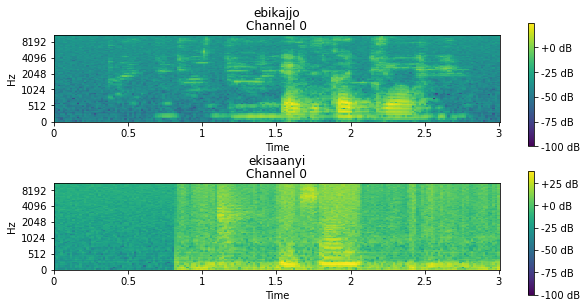

In [13]:
dbunch.show_batch(figsize=(10, 5))

In [14]:
learn = cnn_learner(dbunch, 
            vgg11_bn, 
            config=cnn_config(n_in=1),
            loss_fn=LabelSmoothingCrossEntropy,
            metrics=[accuracy]).to_fp16()

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /home/kkalyan/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


In [15]:
x,y = next(iter(learn.dls.train))

In [16]:
x.shape

torch.Size([128, 1, 128, 188])

In [17]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,7.017206,5.356662,0.005420,00:06


epoch,train_loss,valid_loss,accuracy,time
0,7.147461,5.417204,0.002710,00:07
1,7.181980,5.481493,0.005420,00:07
2,7.134721,5.404268,0.002710,00:08
3,6.981555,5.320903,0.018970,00:07
4,6.815452,5.380670,0.016260,00:08
5,6.610332,5.296863,0.013550,00:06
6,6.414132,5.238497,0.035230,00:07
7,6.254082,5.152471,0.035230,00:07
8,6.111921,5.132809,0.032520,00:07
9,5.997852,5.124674,0.035230,00:08


In [18]:
learn.fit_one_cycle(150, 1e-3, cbs=[EarlyStoppingCallback(patience=20), SaveModelCallback(fname='save-nb-{}'.format(FOLD))])

epoch,train_loss,valid_loss,accuracy,time
0,5.426062,5.223588,0.024390,00:07
1,5.353810,5.166849,0.029810,00:08
2,5.278559,5.213386,0.029810,00:06
3,5.223362,5.062335,0.040650,00:08
4,5.187167,5.007877,0.056911,00:06
5,5.141212,5.010053,0.059621,00:07
6,5.067903,4.999762,0.054201,00:08
7,5.002030,4.862837,0.051491,00:07
8,4.939329,4.911739,0.067751,00:07
9,4.847588,4.883996,0.067751,00:06


Better model found at epoch 0 with valid_loss value: 5.223587989807129.
Better model found at epoch 1 with valid_loss value: 5.166849136352539.
Better model found at epoch 3 with valid_loss value: 5.06233549118042.
Better model found at epoch 4 with valid_loss value: 5.007876873016357.
Better model found at epoch 6 with valid_loss value: 4.999761581420898.
Better model found at epoch 7 with valid_loss value: 4.862836837768555.
Better model found at epoch 10 with valid_loss value: 4.811458587646484.
Better model found at epoch 11 with valid_loss value: 4.743322372436523.
Better model found at epoch 12 with valid_loss value: 4.721532821655273.
Better model found at epoch 13 with valid_loss value: 4.626959800720215.
Better model found at epoch 15 with valid_loss value: 4.4673943519592285.
Better model found at epoch 16 with valid_loss value: 4.446601867675781.
Better model found at epoch 17 with valid_loss value: 4.282824516296387.
Better model found at epoch 18 with valid_loss value: 4.2

In [19]:
learn.load('save-nb-{}'.format(FOLD))

SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=9.120108734350652e-05)

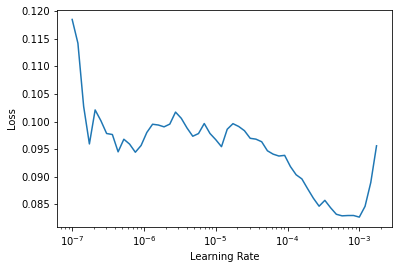

In [20]:
learn.unfreeze()
learn.lr_find(suggestions=True)

In [21]:
learn.fit_one_cycle(150, slice(1e-5, 1e-3), cbs=[EarlyStoppingCallback(patience=20), 
                                                 SaveModelCallback(fname='save-nb-{}'.format(FOLD))])

epoch,train_loss,valid_loss,accuracy,time
0,0.078466,3.123815,0.390244,00:06
1,0.083461,3.116382,0.409214,00:07
2,0.084635,3.085882,0.398374,00:06
3,0.084962,3.052682,0.414634,00:07
4,0.089908,3.068965,0.387534,00:06
5,0.089881,3.060852,0.403794,00:07
6,0.089221,3.075245,0.403794,00:07
7,0.087398,3.064048,0.390244,00:06
8,0.082049,3.016268,0.422764,00:07
9,0.079113,3.044364,0.417344,00:07


Better model found at epoch 0 with valid_loss value: 3.1238150596618652.
Better model found at epoch 1 with valid_loss value: 3.1163816452026367.
Better model found at epoch 2 with valid_loss value: 3.0858817100524902.
Better model found at epoch 3 with valid_loss value: 3.0526821613311768.
Better model found at epoch 8 with valid_loss value: 3.0162675380706787.
Better model found at epoch 22 with valid_loss value: 3.0040171146392822.
No improvement since epoch 22: early stopping


SuggestedLRs(lr_min=9.120108734350651e-06, lr_steep=6.918309736647643e-06)

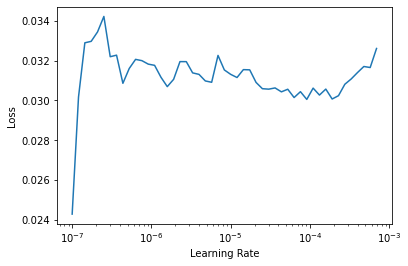

In [22]:
learn.lr_find(suggestions=True)

In [23]:
learn.load('save-nb-{}'.format(FOLD))

In [24]:
learn.fit_one_cycle(150, slice(4e-7, 1e-5), cbs=[EarlyStoppingCallback(patience=20), 
                                                 SaveModelCallback(fname='save-nb-{}'.format(FOLD))])

epoch,train_loss,valid_loss,accuracy,time
0,0.030557,3.047211,0.417344,00:06
1,0.030517,3.025617,0.411924,00:07
2,0.030501,3.058329,0.398374,00:07
3,0.030667,3.056255,0.417344,00:07
4,0.030038,3.042904,0.395664,00:07
5,0.030894,3.048645,0.392954,00:06
6,0.030439,3.017245,0.411924,00:07
7,0.031515,3.032253,0.420054,00:07
8,0.031102,3.056275,0.411924,00:07
9,0.030661,3.042218,0.403794,00:05


Better model found at epoch 0 with valid_loss value: 3.047211170196533.
Better model found at epoch 1 with valid_loss value: 3.0256166458129883.
Better model found at epoch 6 with valid_loss value: 3.017244577407837.
Better model found at epoch 11 with valid_loss value: 3.004031181335449.
Better model found at epoch 18 with valid_loss value: 2.9862139225006104.
Better model found at epoch 19 with valid_loss value: 2.966265916824341.
No improvement since epoch 19: early stopping


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.5848931980144698e-06)

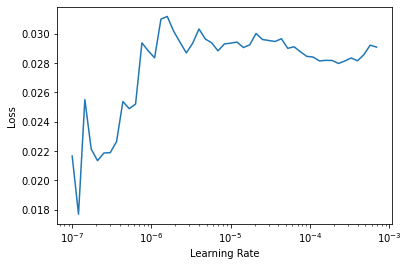

In [25]:
learn.lr_find(suggestions=True)

In [26]:
learn.load('save-nb-{}'.format(FOLD))

In [27]:
learn.fit_one_cycle(150, slice(1e-8, 1e-6), cbs=[EarlyStoppingCallback(patience=20), 
                                                 SaveModelCallback(fname='save-nb-{}'.format(FOLD))])

epoch,train_loss,valid_loss,accuracy,time
0,0.020544,3.012325,0.420054,00:06
1,0.025386,3.031084,0.398374,00:07
2,0.026213,3.002188,0.411924,00:06
3,0.026302,2.997483,0.414634,00:05
4,0.027579,3.023267,0.406504,00:05
5,0.027571,3.050144,0.398374,00:05
6,0.029359,3.046775,0.392954,00:05
7,0.029149,3.025932,0.403794,00:05
8,0.029300,3.031063,0.401084,00:05
9,0.027793,3.015271,0.398374,00:05


Better model found at epoch 0 with valid_loss value: 3.012324571609497.
Better model found at epoch 2 with valid_loss value: 3.0021884441375732.
Better model found at epoch 3 with valid_loss value: 2.997483253479004.
No improvement since epoch 3: early stopping


In [28]:
learn.load('save-nb-{}'.format(FOLD))

In [29]:
preds, y = learn.get_preds(dl=dbunch.valid)
acc = accuracy(preds, y); acc

tensor(0.4146)

In [30]:
ss = pd.read_csv(path/'SampleSubmission.csv')
ss['fn'] = ss.fn.apply(lambda x: str(path)+"/"+x)

tdl = learn.dls.test_dl(ss['fn'].values, order=True)
test_preds, test_labels = learn.get_preds(dl=tdl)

In [31]:
for i, label in enumerate(dbunch.vocab):
    ss[label] = [np.round(t[i].numpy(), 4) for t in test_preds]
ss.head()
ss.to_csv('/home/kkalyan/agri-split/submissions/'+'cv_submit-vgg11_bn-{}.csv'.format(FOLD), index=False)